In [64]:
import itertools as itr
import os
from tqdm import tqdm
from collections import defaultdict

import causaldag as cd
from strategies.simulator import IterationData
from strategies.information_gain import create_info_gain_strategy_dag_collection, create_info_gain_strategy, create_info_gain_strategy_dag_collection_enum
from strategies.random_nodes import random_strategy

from utils import graph_utils
from analysis.check_gies import get_parent_probs_by_dag, get_l1_score

from config import DATA_FOLDER
samples_folder = os.path.join(DATA_FOLDER, 'check-interventions', 'samples')
os.makedirs(samples_folder, exist_ok=True)

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
sns.set()

from scipy.special import logsumexp

from pprint import PrettyPrinter
pp = PrettyPrinter()

In [65]:
def non_isolated_nodes(cpdag):
    undirected_neighbors = cpdag.undirected_neighbors
    return {node for node in cpdag.nodes if cpdag.undirected_neighbors[node]}

def tuplify(s):
    a, b = s.split(',')
    return (int(a), int(b))

def detuplify(t):
    a, b = t
    return '%s,%s' % (a, b)

In [66]:
import numpy as np
import xarray as xr
from sklearn import preprocessing

In [67]:
IV_STRENGTH = 2
nnodes = 10
density = .5
target = int(np.ceil(nnodes/2))-1
nsamples = 100
N_BOOT = 100
runs = 3
nsamples_obs = 1000
target = 1

### Generate graph and check MEC

In [68]:
np.random.seed(100)
true_dag = cd.rand.directed_erdos(nnodes, density)
# true_arcs = {(i+1, i) for i in range(target)} | {(i, i+1) for i in range(target, nnodes-1)}
# true_arcs = {(i+1, i) for i in range(nnodes-1)}
# true_dag = cd.DAG(nodes=set(range(nnodes)), arcs=true_arcs)
# true_dag.arcs

In [69]:
# true_cpdag = true_dag.interventional_cpdag({5}, cpdag=true_dag.cpdag())
true_cpdag = true_dag.cpdag()
true_dag_mec = [cd.DAG(nodes=set(range(nnodes)), arcs=arcs) for arcs in true_cpdag.all_dags()]
intervention_weights = defaultdict(int)
for iv in range(nnodes):
    for poss_dag in true_dag_mec:
        poss_icpdag = poss_dag.interventional_cpdag({iv}, cpdag=true_cpdag)
        intervention_weights[iv] += len(poss_icpdag.arcs) - len(true_cpdag.arcs)
print(len(true_dag_mec))

8


In [70]:
arcs = {(i, j): graph_utils.RAND_RANGE() for i, j in true_dag.arcs}
gdag = cd.GaussDAG(nodes=list(range(nnodes)), arcs=arcs)
obs_samples_unscaled = gdag.sample(nsamples_obs)
obs_samples = [preprocessing.scale(gdag.sample(nsamples_obs)) for run in range(runs)]
np.diag(np.cov(obs_samples[0], rowvar=False))

array([1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001,
       1.001001, 1.001001, 1.001001, 1.001001])

## Plot the graph

In [71]:
def draw_colored(gdag):
    cmap = plt.get_cmap('seismic')
    
    nw_ax = plt.subplot2grid((10, 10), (0, 0), colspan=9, rowspan=9)
    colorbar_ax = plt.subplot2grid((10, 10), (2, 9), rowspan=6)
    
    plt.gcf().set_size_inches(10, 10)
    d = nx.DiGraph()
    for (i, j), w in gdag.arc_weights.items():
        d.add_edge(i, j, weight=w)
    pos = graphviz_layout(d, 'dot')
    edges = d.edges()
    edge_colors = [(cmap((d[i][j]['weight']+1)/2)) for i, j in edges]
    nx.draw(d, pos=pos, node_color='w', edge_color=edge_colors, ax=nw_ax)
    nx.draw_networkx_labels(d, pos, labels={node: node for node in range(10)}, ax=nw_ax);
    
    cb = mpl.colorbar.ColorbarBase(colorbar_ax, cmap=cmap, orientation='vertical')
    cb.set_ticks([0, .5, 1])
    cb.set_ticklabels([-1, 0, 1])

[0][1|0][3|1][2|1][4|0,2][5|4][6|4,5][7|0,2,5,6][9|1,5,6][8|0,1,2,3,6,7]


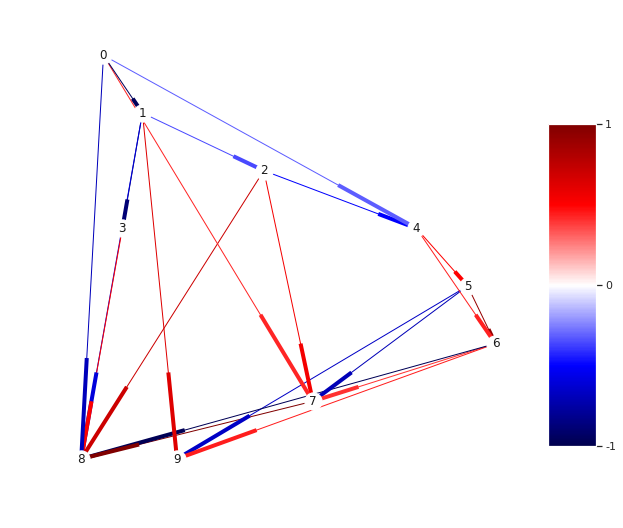

In [72]:
draw_colored(gdag)
print(str(gdag))

In [73]:
intervention_nodes = list(range(nnodes))

iv_type = 'gauss'
if iv_type == 'gauss':
    interventions = [
        cd.GaussIntervention(
            mean=0,
            variance=.1,
        ) for std in np.diag(gdag.covariance)**.5
    ]
else:
    interventions = [
        cd.BinaryIntervention(
            intervention1=cd.ConstantIntervention(val=-IV_STRENGTH*std),
            intervention2=cd.ConstantIntervention(val=IV_STRENGTH*std),
        ) for std in np.diag(gdag.covariance)**.5
    ]
del intervention_nodes[target]
del interventions[target]
print(intervention_nodes)
pp.pprint(interventions)

[0, 2, 3, 4, 5, 6, 7, 8, 9]
[GaussIntervention(mean=0, variance=0.1),
 GaussIntervention(mean=0, variance=0.1),
 GaussIntervention(mean=0, variance=0.1),
 GaussIntervention(mean=0, variance=0.1),
 GaussIntervention(mean=0, variance=0.1),
 GaussIntervention(mean=0, variance=0.1),
 GaussIntervention(mean=0, variance=0.1),
 GaussIntervention(mean=0, variance=0.1),
 GaussIntervention(mean=0, variance=0.1)]


In [11]:
ivs2dags = defaultdict(list)

# Collect DAGs given just observational data

In [ ]:
for run in tqdm(range(runs)):
    folder = os.path.join(samples_folder, 'observational,run%d' % run)
    os.makedirs(folder)
    samples_file = os.path.join(folder, 'samples.csv')
    interventions_folder = os.path.join(folder, 'interventions')
    gies_dags_folder = os.path.join(folder, 'gies_dags/')

    graph_utils._write_data({-1: obs_samples[run]}, samples_file, interventions_folder)
    graph_utils.run_gies_boot(N_BOOT, samples_file, interventions_folder, gies_dags_folder)
    amats, dags = graph_utils._load_dags(gies_dags_folder)

    ivs2dags[-1].append(dags)

# Collect DAGs given interventional data

In [ ]:
for iv_node, intervention in tqdm(zip(intervention_nodes, interventions), total=len(interventions)):
    for run in range(runs):
        samples = gdag.sample_interventional({iv_node: intervention}, nsamples)
        samples = preprocessing.scale(samples)
        all_samples = {-1: obs_samples[run], iv_node: samples}
        folder = os.path.join(samples_folder, 'iv=%d,run%d' % (iv_node, run))
        os.makedirs(folder)

        samples_file = os.path.join(folder, 'samples.csv')
        interventions_folder = os.path.join(folder, 'interventions')
        gies_dags_folder = os.path.join(folder, 'gies_dags/')
        graph_utils._write_data(all_samples, samples_file, interventions_folder)
        graph_utils.run_gies_boot(N_BOOT, samples_file, interventions_folder, gies_dags_folder)

        amats, dags = graph_utils._load_dags(gies_dags_folder)
        ivs2dags[iv_node].append(dags)

# Count the occurrences of each arc in the sampled DAGs

In [ ]:
ivs2parent_probs = xr.DataArray(
    np.zeros([len(interventions) + 1, len(gdag.nodes), runs]),
    dims=['iv_node', 'parent', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'parent': gdag.nodes,
        'run': list(range(runs))
    }
)
possible_arcs = list(itr.permutations(gdag.nodes, 2))
ivs2arc_probs = xr.DataArray(
    np.zeros([len(interventions) + 1, len(possible_arcs), runs]),
    dims=['iv_node', 'arc', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'arc': list(map(detuplify, possible_arcs)),
        'run': list(range(runs))
    }
)
for iv_node, dags_by_run in ivs2dags.items():
    for run, dags in enumerate(dags_by_run):
        parent_counts = {node: 0 for node in gdag.nodes}
        arc_counts = defaultdict(int)
        for dag in dags:
            for p in dag.parents[target]:
                parent_counts[p] += 1
            for arc in dag.arcs:
                arc_counts[arc] += 1
        for parent, count in parent_counts.items():
            ivs2parent_probs.loc[dict(run=run, iv_node=iv_node, parent=p)] = count/len(dags)
        for arc, count in arc_counts.items():
            ivs2arc_probs.loc[dict(run=run, iv_node=iv_node, arc=detuplify(arc))] = count/len(dags)

# From the arc occurrences, compute l1 scores

#### functions

In [ ]:
def l1_score_full(arc_probs, gdag):
    possible_arcs = set(itr.permutations(gdag.nodes, 2))
    nonarcs = possible_arcs - gdag.arcs
    return sum(1-arc_probs[arc] for arc in gdag.arcs) + sum(arc_probs[nonarc] for nonarc in nonarcs)


def l1_score_fp_full(arc_probs, gdag):
    possible_arcs = set(itr.permutations(gdag.nodes, 2))
    nonarcs = possible_arcs - gdag.arcs
    return sum(arc_probs[nonarc] for nonarc in nonarcs)


def l1_score_fn_full(arc_probs, gdag):
    return sum(1-arc_probs[arc] for arc in gdag.arcs)

#### actual computation

In [ ]:
ivs2scores = xr.DataArray(
    np.zeros([len(interventions) + 1, runs]),
    dims=['iv_node', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'run': list(range(runs))
    }
)
for iv_node in intervention_nodes + [-1]:
    for run in range(runs):
        parent_probs = {node: ivs2parent_probs.sel(iv_node=iv_node, parent=node, run=run) for node in gdag.nodes}
        ivs2scores.loc[dict(iv_node=iv_node, run=run)] = get_l1_score(parent_probs, gdag, target)

max_l1_loss_full = nnodes*(nnodes-1)
max_l1_loss_fn = len(gdag.arcs)
max_l1_loss_fp = max_l1_loss_full - max_l1_loss_fn
ivs2full_scores = xr.DataArray(
    np.zeros([len(interventions) + 1, runs]),
    dims=['iv_node', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'run': list(range(runs))
    }
)
ivs2full_scores_fp = xr.DataArray(
    np.zeros([len(interventions) + 1, runs]),
    dims=['iv_node', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'run': list(range(runs))
    }
)
ivs2full_scores_fn = xr.DataArray(
    np.zeros([len(interventions) + 1, runs]),
    dims=['iv_node', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'run': list(range(runs))
    }
)
for iv_node in intervention_nodes + [-1]:
    for run in range(runs):
        arc_probs = {arc: ivs2arc_probs.sel(iv_node=iv_node, arc=detuplify(arc), run=run).values.item() for arc in possible_arcs}
        ivs2full_scores.loc[dict(iv_node=iv_node, run=run)] = l1_score_full(arc_probs, gdag)
        ivs2full_scores_fp.loc[dict(iv_node=iv_node, run=run)] = l1_score_fp_full(arc_probs, gdag)
        ivs2full_scores_fn.loc[dict(iv_node=iv_node, run=run)] = l1_score_fn_full(arc_probs, gdag)

        

# Plot effectiveness of each intervention

#### L1-score targeting just learning parents

In [ ]:
plt.title('Accuracy of %d samples from GIES bootstrap \n after %d interventional samples \n intervention strength = %s' % (N_BOOT, nsamples, IV_STRENGTH))
plt.stem(intervention_nodes, ivs2scores.sel(iv_node=intervention_nodes,run=0))
plt.stem(np.array(intervention_nodes) + .1, ivs2scores.sel(iv_node=intervention_nodes,run=1))
plt.stem(np.array(intervention_nodes) + .2, ivs2scores.sel(iv_node=intervention_nodes,run=2))

plt.axhline(ivs2scores.sel(iv_node=-1, run=2), color='red', label='%d Observational Samples' % nsamples_obs)
plt.xlabel('Intervened node')
plt.xticks(gdag.nodes)
plt.ylabel('L1 loss on edges coming into node 5')
plt.legend();

#### L1-score on full graph

In [ ]:
plt.title('Accuracy of %d samples from GIES bootstrap \n after %d interventional samples \n intervention strength = %s' % (N_BOOT, nsamples, IV_STRENGTH))
plt.stem(intervention_nodes, ivs2full_scores.sel(iv_node=intervention_nodes,run=0))
plt.stem(np.array(intervention_nodes) + .1, ivs2full_scores.sel(iv_node=intervention_nodes,run=1))
plt.stem(np.array(intervention_nodes) + .2, ivs2full_scores.sel(iv_node=intervention_nodes,run=2))

plt.axhline(ivs2full_scores.sel(iv_node=-1, run=2), color='red', label='%d Observational Samples' % nsamples_obs)
plt.xlabel('Intervened node')
plt.xticks(gdag.nodes)
plt.ylabel('L1 loss on all edges')

# A bunch of annoying code to get right-hand yaxis lookin' nice
ax1 = plt.gca()
yticks, _ = plt.yticks()
ax = plt.twinx()
ax.set_yticks(yticks)
ax.set_yticklabels(map(lambda y: '%.2f' % (y / max_l1_loss_full), yticks))
ax.grid(False)
ax.set_ylabel('Percent of maximum L1 loss')

plt.legend();

#### L1-score on false negatives

In [ ]:
plt.title('Accuracy of %d samples from GIES bootstrap \n after %d interventional samples \n intervention strength = %s' % (N_BOOT, nsamples, IV_STRENGTH))
plt.stem(intervention_nodes, ivs2full_scores_fn.sel(iv_node=intervention_nodes,run=0))
plt.stem(np.array(intervention_nodes) + .1, ivs2full_scores_fn.sel(iv_node=intervention_nodes,run=1))
plt.stem(np.array(intervention_nodes) + .2, ivs2full_scores_fn.sel(iv_node=intervention_nodes,run=2))

plt.axhline(ivs2full_scores_fn.sel(iv_node=-1, run=2), color='red', label='%d Observational Samples' % nsamples_obs)
plt.xlabel('Intervened node')
plt.xticks(gdag.nodes)
plt.ylabel('L1 loss with only false negatives')

# A bunch of annoying code to get right-hand yaxis lookin' nice
ax1 = plt.gca()
yticks, _ = plt.yticks()
ax = plt.twinx()
ax.set_yticks(yticks)
ax.set_yticklabels(map(lambda y: '%.2f' % (y / max_l1_loss_fn), yticks))
ax.grid(False)
ax.set_ylabel('Percent of maximum L1 loss')

plt.legend();

#### L1-score on false positives

In [ ]:
plt.title('Accuracy of %d samples from GIES bootstrap \n after %d interventional samples \n intervention strength = %s' % (N_BOOT, nsamples, IV_STRENGTH))
plt.stem(intervention_nodes, ivs2full_scores_fp.sel(iv_node=intervention_nodes,run=0))
plt.stem(np.array(intervention_nodes) + .1, ivs2full_scores_fp.sel(iv_node=intervention_nodes,run=1))
plt.stem(np.array(intervention_nodes) + .2, ivs2full_scores_fp.sel(iv_node=intervention_nodes,run=2))

plt.axhline(ivs2full_scores_fp.sel(iv_node=-1, run=2), color='red', label='%d Observational Samples' % nsamples_obs)
plt.xlabel('Intervened node')
plt.xticks(gdag.nodes)
plt.ylabel('L1 loss with only false positives')

# A bunch of annoying code to get right-hand yaxis lookin' nice
ax1 = plt.gca()
yticks, _ = plt.yticks()
ax = plt.twinx()
ax.set_yticks(yticks)
ax.set_yticklabels(map(lambda y: '%.2f' % (y / max_l1_loss_fp), yticks))
ax.grid(False)
ax.set_ylabel('Percent of maximum L1 loss')

plt.legend();

In [ ]:
# def get_parent_functional(parent):
#     def parent_functional(dag):
#         return parent in dag.parents[target]
#     return parent_functional

# parent_functionals = [get_parent_functional(node) for node in gdag.nodes if node != target]

In [ ]:
# info_strat = create_info_gain_strategy(50, parent_functionals)

# info_strat(iteration_data)

In [ ]:
ivs2parent_probs.sel(iv_node=0, run=1)

In [ ]:
ivs2parent_probs.sel(iv_node=0, run=2)

In [ ]:
ivs2scores.sel(iv_node=0, run=1)

In [ ]:
ivs2scores.sel(iv_node=0, run=2)

In [ ]:
ivs2scores.sel(iv_node=0, run=0)

In [ ]:
def marginal_network(ivs2arc_probs, iv, run, mode='both'):
    arc_probs = ivs2arc_probs.sel(iv_node=iv, run=run)
    d = nx.DiGraph()
    d.add_nodes_from(gdag.nodes)
    for arc, prob in zip(possible_arcs, arc_probs.data):
        i, j = arc
        if prob != 0:
            if mode == 'both' or (mode == 'forward' and i<j) or (mode == 'backward' and i > j):
                d.add_edge(*arc, weight=prob)
    return d

In [ ]:
draw_colored(gdag)

In [ ]:
cmap = plt.get_cmap('Greys')
fig, axes = plt.subplots(len(interventions)+1, runs*2)
unit = 6
width = unit*runs*2
height = unit*(len(interventions) + 1)
fig.set_size_inches(width, height)

pos = nx.circular_layout(gdag.nodes)

for run in range(runs):
    for iv_ix, iv_node in enumerate([-1] + intervention_nodes):
        forward_ax = axes[iv_ix, run*2]
        backward_ax = axes[iv_ix, run*2+1]
        
        m = marginal_network(ivs2arc_probs, iv_node, run, mode='forward')
        edges = m.edges()
        edge_colors = [cmap(m[i][j]['weight']) for i, j in edges]
        nx.draw(m, pos=pos, node_color='w', edge_color=edge_colors, ax=forward_ax)
        nx.draw_networkx_edges(m, pos, edge_color=edge_colors, ax=forward_ax, arrowstyle='fancy')
        nx.draw_networkx_labels(m, pos, labels={node: node for node in range(10)}, ax=forward_ax)
        
        m = marginal_network(ivs2arc_probs, iv_node, run, mode='backward')
        edges = m.edges()
        edge_colors = [cmap(m[i][j]['weight']) for i, j in edges]
        nx.draw(m, pos=pos, node_color='w', edge_color=edge_colors, ax=backward_ax)
        nx.draw_networkx_edges(m, pos, edge_color=edge_colors, ax=backward_ax, arrowstyle='fancy')
        nx.draw_networkx_labels(m, pos, labels={node: node for node in range(10)}, ax=backward_ax);
        
        if iv_ix == 0:
            forward_ax.set_title('Run %d' % run)
            backward_ax.set_title('Run %d' % run)
        if run == 0:
            forward_ax.text(-1, -1, 'I=%s' % iv_node if iv_node != -1 else 'Obs')

# RESUME HERE

In [ ]:
def get_isdag_functional(dag):
    def isdag(test_dag):
        return dag.arcs == test_dag.arcs
    return isdag

mec_functionals = [get_isdag_functional(dag) for dag in true_dag_mec]
list(map(lambda m: m(true_dag), mec_functionals))

# def get_binary_entropy(p)

In [19]:
def get_mec_functional_k(dag_collection):
    def get_dag_ix_mec(dag):
        print(len(dag.arcs))
        return next(d_ix for d_ix, d in enumerate(dag_collection) if d.arcs == dag.arcs)
    return get_dag_ix_mec


def get_k_entropy_fxn(k):
    def get_k_entropy(fvals, weights):
        # find probs
        probs = np.zeros(k)
        for fval, w in zip(fvals, weights):
            probs[fval] += w

        # = find entropy
        mask = probs != 0
        plogps = np.zeros(len(probs))
        plogps[mask] = np.log2(probs[mask]) * probs[mask]
        ent = -plogps.sum()
        return ent

    return get_k_entropy

mec_functional_k = get_mec_functional_k(true_dag_mec)
k_entropy_fxn = get_k_entropy_fxn(len(true_dag_mec))
print(mec_functional_k(true_dag))

21
6


In [20]:
def parent_functionals(target, nodes):
    def get_parent_functional(parent):
        def parent_functional(dag):
            return parent in dag.parents[target]
        return parent_functional

    return [get_parent_functional(node) for node in nodes if node != target]

In [21]:
def descendant_functionals(target, nodes):
    def get_descendant_functional(descendant):
        def descendant_functional(dag):
            return descendant in dag.downstream(target)
        return descendant_functional

    return [get_descendant_functional(node) for node in nodes if node != target]

binary_entropy_fxn = get_k_entropy_fxn(2)

In [22]:
d_functionals = descendant_functionals(target, true_dag.nodes)
d_functionals_entropies = [binary_entropy_fxn]*len(d_functionals)

In [23]:
def pdfs2l1_functionals(pdfs, mec, binary_functionals):
    l1 = 0
    for f in binary_functionals:
        f_prob = 0
        for p, g in zip(pdfs, mec):
            f_prob += f(g) * p
        l1 += np.abs(f(true_dag) - f_prob)
    return l1

print(pdfs2l1_functionals([1/len(true_dag_mec)]*len(true_dag_mec), true_dag_mec, d_functionals))

1.25


In [24]:
print([f(gdag) for f in d_functionals])
print(gdag.nodes)
print(gdag.downstream(target))

[False, True, True, True, True, True, True, True, True]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
{2, 3, 4, 5, 6, 7, 8, 9}


## Run Strategies

In [52]:
minibatch_size = 10
nsamples = 99
max_interventions = 3

In [53]:
# dag_collection_info_strat = create_info_gain_strategy_dag_collection(
#     true_dag_mec, 
#     [mec_functional_k], 
#     [k_entropy_fxn], 
#     gauss_iv=iv_type=='gauss',
#     minibatch_size=minibatch_size
# )

dag_collection_info_strat = create_info_gain_strategy_dag_collection(
    true_dag_mec, 
    d_functionals, 
    d_functionals_entropies, 
    gauss_iv=iv_type=='gauss',
    minibatch_size=minibatch_size
)

dag_collection_info_strat_folder = os.path.join(DATA_FOLDER, 'dag-collection-erdos/')
os.makedirs(dag_collection_info_strat_folder, exist_ok=True)

iteration_data_dag_collection_info_strat = IterationData(
    current_data={-1: obs_samples_unscaled},
    max_interventions=max_interventions,
    n_samples=nsamples,
    batch_num=1,
    n_batches=1,
    intervention_set=intervention_nodes,
    interventions=interventions,
    batch_folder=dag_collection_info_strat_folder,
    precision_matrix=gdag.precision
)


In [54]:
dag_collection_datas = []
all_dag_collection_interventions = []
for i in range(10):
    dag_collection_interventions = dag_collection_info_strat(iteration_data_dag_collection_info_strat)
    all_dag_collection_interventions.append(dag_collection_interventions)
    dag_collection_data = {
        iv: gdag.sample_interventional({iv: interventions[iv]}, samples) 
        for iv, samples in dag_collection_interventions.items()
    }
    dag_collection_data[-1] = obs_samples_unscaled
    dag_collection_datas.append(dag_collection_data)

 38%|███▊      | 3/8 [00:00<00:00, 20.91it/s]]


[21, 21, 21, 21, 21, 21, 21, 21]
[21, 21, 21, 21, 21, 21, 21, 21]
[set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES


 40%|████      | 4/10 [00:00<00:00, 18.46it/s]

ALLOCATING SAMPLES


  0%|          | 0/9 [00:00<?, ?it/s]

[21, 21, 21, 21, 21, 21, 21, 21]
[21, 21, 21, 21, 21, 21, 21, 21]
[set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 40%|████      | 4/10 [00:00<00:00, 18.46it/s]

ALLOCATING SAMPLES


  0%|          | 0/9 [00:00<?, ?it/s]

[21, 21, 21, 21, 21, 21, 21, 21]
[21, 21, 21, 21, 21, 21, 21, 21]
[set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 40%|████      | 4/10 [00:00<00:00, 18.49it/s]

ALLOCATING SAMPLES


  0%|          | 0/9 [00:00<?, ?it/s]

[21, 21, 21, 21, 21, 21, 21, 21]
[21, 21, 21, 21, 21, 21, 21, 21]
[set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 40%|████      | 4/10 [00:00<00:00, 18.47it/s]

ALLOCATING SAMPLES


  0%|          | 0/9 [00:00<?, ?it/s]

[21, 21, 21, 21, 21, 21, 21, 21]
[21, 21, 21, 21, 21, 21, 21, 21]
[set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 40%|████      | 4/10 [00:00<00:00, 18.48it/s]

ALLOCATING SAMPLES


  0%|          | 0/9 [00:00<?, ?it/s]

[21, 21, 21, 21, 21, 21, 21, 21]
[21, 21, 21, 21, 21, 21, 21, 21]
[set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 40%|████      | 4/10 [00:00<00:00, 18.26it/s]

ALLOCATING SAMPLES


  0%|          | 0/9 [00:00<?, ?it/s]

[21, 21, 21, 21, 21, 21, 21, 21]
[21, 21, 21, 21, 21, 21, 21, 21]
[set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 40%|████      | 4/10 [00:00<00:00, 18.19it/s]

ALLOCATING SAMPLES


  0%|          | 0/9 [00:00<?, ?it/s]

[21, 21, 21, 21, 21, 21, 21, 21]
[21, 21, 21, 21, 21, 21, 21, 21]
[set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 40%|████      | 4/10 [00:00<00:00, 18.19it/s]

ALLOCATING SAMPLES


  0%|          | 0/9 [00:00<?, ?it/s]

[21, 21, 21, 21, 21, 21, 21, 21]
[21, 21, 21, 21, 21, 21, 21, 21]
[set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 40%|████      | 4/10 [00:00<00:00, 18.12it/s]

ALLOCATING SAMPLES


  0%|          | 0/9 [00:00<?, ?it/s]

[21, 21, 21, 21, 21, 21, 21, 21]
[21, 21, 21, 21, 21, 21, 21, 21]
[set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 40%|████      | 4/10 [00:00<00:00, 18.20it/s]

ALLOCATING SAMPLES


100%|██████████| 10/10 [00:00<00:00, 18.57it/s]


In [55]:
all_dag_collection_interventions

[defaultdict(int, {2: 40, 0: 59}),
 defaultdict(int, {2: 40, 0: 59}),
 defaultdict(int, {2: 40, 0: 59}),
 defaultdict(int, {2: 40, 0: 59}),
 defaultdict(int, {2: 40, 0: 59}),
 defaultdict(int, {2: 40, 0: 59}),
 defaultdict(int, {2: 40, 0: 59}),
 defaultdict(int, {2: 40, 0: 59}),
 defaultdict(int, {2: 40, 0: 59}),
 defaultdict(int, {2: 40, 0: 59})]

In [75]:
bootstrap_info_strat = create_info_gain_strategy(100, d_functionals)
bootstrap_info_strat_folder = os.path.join(DATA_FOLDER, 'bootstrap-info-test-er-new/')
os.makedirs(bootstrap_info_strat_folder, exist_ok=True)

iteration_data_bootstrap_info_strat = IterationData(
    current_data={-1: obs_samples_unscaled},
    max_interventions=max_interventions,
    n_samples=nsamples,
    batch_num=1,
    n_batches=1,
    intervention_set=intervention_nodes,
    interventions=interventions,
    batch_folder=bootstrap_info_strat_folder,
    precision_matrix=gdag.precision
)

gies_datas = []
all_gies_interventions = []
for i in range(10):
    gies_interventions = bootstrap_info_strat(iteration_data_bootstrap_info_strat)
    all_gies_interventions.append(gies_interventions)
    gies_data = {
        iv: gdag.sample_interventional({iv: interventions[iv]}, samples) 
        for iv, samples in dag_collection_interventions.items()
    }
    gies_data[-1] = obs_samples_unscaled
    gies_datas.append(gies_data)

All DAGs deleted in /home/ubuntu/active_learning/new/data/bootstrap-info-test-er-new/TEMP_DAGS/
COLLECTING DATA POINTS


 11%|█         | 1/9 [00:00<00:01,  6.85it/s]

CALCULATING LOG PDFS



 56%|█████▌    | 5/9 [00:00<00:00,  6.25it/s]


100%|██████████| 9/9 [00:01<00:00,  6.12it/s]


 22%|██▏       | 2/9 [00:00<00:01,  6.62it/s]


 67%|██████▋   | 6/9 [00:00<00:00,  6.20it/s]


 77%|███████▋  | 77/100 [01:52<00:33,  1.47s/it]


 33%|███▎      | 3/9 [00:00<00:00,  6.46it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

COLLECTING SAMPLES


100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


All DAGs deleted in /home/ubuntu/active_learning/new/data/bootstrap-info-test-er-new/TEMP_DAGS/
COLLECTING DATA POINTS


 11%|█         | 1/9 [00:00<00:01,  6.68it/s]

CALCULATING LOG PDFS



 56%|█████▌    | 5/9 [00:00<00:00,  6.20it/s]


100%|██████████| 9/9 [00:01<00:00,  6.04it/s]


 22%|██▏       | 2/9 [00:00<00:01,  6.56it/s]


 67%|██████▋   | 6/9 [00:00<00:00,  6.12it/s]


 77%|███████▋  | 77/100 [01:54<00:34,  1.49s/it]


 44%|████▍     | 4/9 [00:00<00:00,  6.22it/s]


KeyboardInterrupt: 

In [57]:
print(intervention_nodes)
print(interventions)

[0, 2, 3, 4, 5, 6, 7, 8, 9]
[GaussIntervention(mean=0, variance=0.1), GaussIntervention(mean=0, variance=0.1), GaussIntervention(mean=0, variance=0.1), GaussIntervention(mean=0, variance=0.1), GaussIntervention(mean=0, variance=0.1), GaussIntervention(mean=0, variance=0.1), GaussIntervention(mean=0, variance=0.1), GaussIntervention(mean=0, variance=0.1), GaussIntervention(mean=0, variance=0.1)]


In [58]:
iteration_data_random = IterationData(
    current_data={-1: obs_samples_unscaled},
    max_interventions=max_interventions,
    n_samples=nsamples,
    batch_num=1,
    n_batches=1,
    intervention_set=intervention_nodes,
    interventions=interventions,
    batch_folder=os.path.join(DATA_FOLDER, 'test-random'),
    precision_matrix=gdag.precision
)
random_datas = []
for i in range(100):
    random_interventions = random_strategy(iteration_data_random)
    print(random_interventions)
    random_data = {iv: gdag.sample_interventional({iv: interventions[intervention_nodes.index(iv)]}, samples) for iv, samples in random_interventions.items()}
    random_data[-1] = obs_samples_unscaled
    random_datas.append(random_data)
    

{0: 33, 8: 33, 4: 33}
{7: 33, 0: 33, 8: 33}
{0: 33, 9: 33, 2: 33}
{3: 33, 8: 33, 5: 33}
{7: 33, 6: 33, 9: 33}
{5: 33, 9: 33, 6: 33}
{8: 33, 4: 33, 2: 33}
{6: 33, 0: 33, 2: 33}
{0: 33, 8: 33, 7: 33}
{9: 33, 4: 33, 5: 33}
{2: 33, 6: 33, 8: 33}
{5: 33, 2: 33, 0: 33}
{2: 33, 3: 33, 9: 33}
{3: 33, 6: 33, 5: 33}
{2: 33, 5: 33, 3: 33}
{3: 33, 5: 33, 4: 33}
{7: 33, 5: 33, 4: 33}
{3: 33, 5: 33, 0: 33}
{3: 33, 0: 33, 4: 33}
{3: 33, 7: 33, 2: 33}
{9: 33, 5: 33, 4: 33}
{0: 33, 8: 33, 3: 33}
{2: 33, 4: 33, 7: 33}
{2: 33, 4: 33, 6: 33}
{2: 33, 0: 33, 5: 33}
{0: 33, 5: 33, 8: 33}
{8: 33, 6: 33, 2: 33}
{6: 33, 5: 33, 4: 33}
{2: 33, 3: 33, 9: 33}
{4: 33, 2: 33, 8: 33}
{8: 33, 3: 33, 4: 33}
{6: 33, 3: 33, 0: 33}
{2: 33, 4: 33, 6: 33}
{9: 33, 6: 33, 5: 33}
{7: 33, 0: 33, 2: 33}
{2: 33, 9: 33, 6: 33}
{7: 33, 9: 33, 4: 33}
{6: 33, 0: 33, 9: 33}
{0: 33, 2: 33, 6: 33}
{4: 33, 8: 33, 6: 33}
{3: 33, 0: 33, 8: 33}
{8: 33, 0: 33, 6: 33}
{4: 33, 9: 33, 3: 33}
{9: 33, 8: 33, 0: 33}
{2: 33, 8: 33, 3: 33}
{3: 33, 5:

In [59]:
intervention_set_random_smart = [node for node in non_isolated_nodes(true_cpdag) if node != target]
print(intervention_set_random_smart)
interventions_random_smart = [interventions[node] for node in intervention_set_random_smart]

iteration_data_random_smart = IterationData(
    current_data={-1: obs_samples_unscaled},
    max_interventions=max_interventions,
    n_samples=nsamples,
    batch_num=1,
    n_batches=1,
    intervention_set=intervention_set_random_smart,
    interventions=interventions_random_smart,
    batch_folder=os.path.join(DATA_FOLDER, 'test-random-smart'),
    precision_matrix=gdag.precision
)
random_smart_datas = []
for i in range(100):
    random_interventions = random_strategy(iteration_data_random_smart)
    print(random_interventions)
    random_smart_data = {iv: gdag.sample_interventional({iv: interventions[intervention_nodes.index(iv)]}, samples) for iv, samples in random_interventions.items()}
    random_smart_data[-1] = obs_samples_unscaled
    random_smart_datas.append(random_smart_data)
    

[0, 2, 3, 5, 6]
{5: 33, 2: 33, 0: 33}
{0: 33, 6: 33, 2: 33}
{5: 33, 3: 33, 2: 33}
{5: 33, 0: 33, 3: 33}
{0: 33, 6: 33, 2: 33}
{5: 33, 0: 33, 3: 33}
{0: 33, 3: 33, 2: 33}
{0: 33, 5: 33, 2: 33}
{2: 33, 0: 33, 5: 33}
{3: 33, 5: 33, 6: 33}
{0: 33, 5: 33, 3: 33}
{0: 33, 2: 33, 5: 33}
{3: 33, 5: 33, 0: 33}
{5: 33, 0: 33, 6: 33}
{0: 33, 5: 33, 2: 33}
{6: 33, 2: 33, 0: 33}
{6: 33, 3: 33, 0: 33}
{5: 33, 2: 33, 0: 33}
{2: 33, 5: 33, 0: 33}
{5: 33, 6: 33, 2: 33}
{5: 33, 6: 33, 0: 33}
{3: 33, 2: 33, 6: 33}
{0: 33, 3: 33, 5: 33}
{3: 33, 5: 33, 0: 33}
{6: 33, 3: 33, 5: 33}
{2: 33, 6: 33, 0: 33}
{3: 33, 2: 33, 6: 33}
{0: 33, 5: 33, 2: 33}
{2: 33, 0: 33, 3: 33}
{0: 33, 2: 33, 6: 33}
{3: 33, 2: 33, 5: 33}
{2: 33, 3: 33, 5: 33}
{5: 33, 2: 33, 0: 33}
{0: 33, 2: 33, 6: 33}
{0: 33, 2: 33, 3: 33}
{2: 33, 3: 33, 5: 33}
{5: 33, 2: 33, 0: 33}
{2: 33, 3: 33, 0: 33}
{5: 33, 0: 33, 2: 33}
{6: 33, 0: 33, 5: 33}
{2: 33, 3: 33, 6: 33}
{0: 33, 2: 33, 6: 33}
{5: 33, 0: 33, 6: 33}
{2: 33, 3: 33, 6: 33}
{6: 33, 2: 33, 3

In [60]:
true_dag_mec_gauss = [graph_utils.cov2dag(gdag.covariance, dag) for dag in true_dag_mec]

In [61]:
def dag_posterior(dag_collec, data):
    logpdfs = np.zeros(len(true_dag_mec))
    for dag_ix, cand_dag in enumerate(dag_collec):
        for iv, samples in data.items():
            if iv == -1:
                logpdfs[dag_ix] += cand_dag.logpdf(samples).sum()
            else:
                iv_ix = intervention_nodes.index(iv)
                logpdfs[dag_ix] += cand_dag.logpdf(samples, interventions={iv: interventions[iv_ix]}).sum()
    return np.exp(logpdfs - logsumexp(logpdfs))

In [62]:
posteriors_dag_collection = [dag_posterior(true_dag_mec_gauss, dag_collection_data) for dag_collection_data in dag_collection_datas]
posteriors_random = [dag_posterior(true_dag_mec_gauss, random_data) for random_data in random_datas]
posteriors_random_smart = [dag_posterior(true_dag_mec_gauss, random_data) for random_data in random_smart_datas]


In [76]:
posteriors_gies = [dag_posterior(true_dag_mec_gauss, gies_data) for gies_data in gies_datas]

In [79]:
true_dag_ix = next(ix for ix, d in enumerate(true_dag_mec) if d.arcs == true_dag.arcs)
def pdfs2l1(pdfs, true_dag_ix):
    return (1-pdfs[true_dag_ix] + pdfs[:true_dag_ix].sum() + pdfs[true_dag_ix+1:].sum())

def pdfs2ent(pdfs):
    plogps = np.zeros(len(pdfs))
    mask = pdfs != 0
    plogps[mask] = pdfs[mask] * np.log2(pdfs[mask])
    return -plogps.sum()

In [80]:
ents_dag_collection = [pdfs2ent(post) for post in posteriors_dag_collection]
print(ents_dag_collection)
print(np.mean(ents_dag_collection))

[1.0309016308304018, 1.0384858132719064, 1.008191186216583, 1.0233705560981405, 1.0349667011365087, 1.2028265918738335, 1.00047111748679, 1.0233728026330857, 1.0002785487320245, 1.091355344631328]
1.04542202929106


In [81]:
l1s_random = [pdfs2l1(post, true_dag_ix) for post in posteriors_random]
ents_random = [pdfs2ent(post) for post in posteriors_random]
print(np.mean(ents_random))

1.8301466407605493


In [82]:
l1s_random_smart = [pdfs2l1(post, true_dag_ix) for post in posteriors_random_smart]
ents_random_smart = [pdfs2ent(post) for post in posteriors_random_smart]
print(ents_random_smart)
print(np.mean(ents_random_smart))

[0.14219254156907177, 0.10686093533942595, 1.5580339312429157, 1.640635875995395, 1.4360180825601876, 0.1533284657088972, 1.043790598540446, 0.6505392097871215, 0.5074682754674161, 1.5849641681445545, 0.9811107535255702, 1.7081272433085715, 0.029652676601040644, 0.5218170684129906, 0.7951118540903597, 0.28590670986850153, 1.756511107556511, 0.058981105178516596, 0.3352588078891089, 1.9378032770653149, 0.6997158406598478, 1.423145483554149, 0.1334755429375159, 1.6514495796320645, 1.5850896708350866, 0.07464685298279425, 1.5948908926839889, 0.6754791490885845, 1.1425104857821178, 0.08967149187922983, 1.6179368228989486, 1.197904528333926, 0.5389320932258257, 1.626235477061739, 1.1211701788803132, 1.7058912954548353, 0.05309888030612449, 1.1530588162559086, 1.8356338309580251, 0.27648171865352, 1.582104704626999, 1.0106709572432837, 1.6821601263393324, 2.758380547125492, 1.5682929947083641, 0.3110717781798852, 1.095374733826669, 1.5967207153400138, 1.9701342907433066, 0.24897059866616109,

In [83]:
l1s_gies = [pdfs2l1(post, true_dag_ix) for post in posteriors_gies]

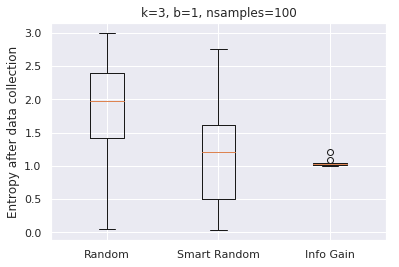

In [84]:
plt.boxplot([ents_random, ents_random_smart, ents_dag_collection], positions=[1, 2, 3]);
plt.ylabel('Entropy after data collection')
plt.gca().set_xticklabels(['Random', 'Smart Random', 'Info Gain']);
plt.title('k=%s, b=%s, nsamples=%s' % (max_interventions, 1, nsamples));

In [86]:
l1s_descendants_dag_collection = [pdfs2l1_functionals(post, true_dag_mec, d_functionals) for post in posteriors_dag_collection]
print(np.mean(l1s_descendants_dag_collection))

l1s_descendants_random = [pdfs2l1_functionals(post, true_dag_mec, d_functionals) for post in posteriors_random]
print(np.mean(l1s_descendants_random))

l1s_descendants_random_smart = [pdfs2l1_functionals(post, true_dag_mec, d_functionals) for post in posteriors_random_smart]
print(np.mean(l1s_descendants_random_smart))

l1s_descendants_gies = [pdfs2l1_functionals(post, true_dag_mec, d_functionals) for post in posteriors_gies]
print(np.mean(l1s_descendants_gies))

0.008071149791417995
0.8024907527021863
0.522511438839611
0.02733188700192278


## miscellaneous

In [ ]:
import causaldag as cd
import numpy as np
B = np.zeros((3, 3))
B[0, 1] = 2
B[0, 2] = 3
B[1, 2] = 5
iv_var = .1
gdag = cd.GaussDAG.from_amat(B)
iv = cd.GaussIntervention(mean=0, variance=iv_var)
samples = gdag.sample(1000)
iv_samples = gdag.sample_interventional({0: iv}, nsamples=100000)

In [ ]:
est_cov = np.cov(samples, rowvar=False)
print(est_cov)
print(gdag.covariance)

In [ ]:
est_cov_iv = np.cov(iv_samples, rowvar=False)
print(est_cov_iv)
print(graph_utils.get_covariance_interventional(gdag, 0, iv_var))

In [ ]:
def get_gies_dags(samples_dict, foldername):
    folder = os.path.join(DATA_FOLDER, foldername)
    os.makedirs(folder, exist_ok=True)

    samples_file = os.path.join(folder, 'samples.csv')
    interventions_folder = os.path.join(folder, 'interventions')
    gies_dags_folder = os.path.join(folder, 'gies_dags/')
    graph_utils._write_data(samples_dict, samples_file, interventions_folder)
    graph_utils.run_gies_boot(N_BOOT, samples_file, interventions_folder, gies_dags_folder)

    amats, dags = graph_utils._load_dags(gies_dags_folder)
    return dags

In [ ]:
def get_arc_probs(dags):
    arc_counts = defaultdict(int)
    for dag in dags:
        for arc in dag.arcs:
            arc_counts[arc] += 1
    return defaultdict(float, {arc: count/len(dags) for arc, count in arc_counts.items()})

In [ ]:
def get_arc_probs_new(nnodes, dags):
    poss_arcs = set(itr.permutations(range(nnodes), 2))
    counts = {arc: 0 for arc in poss_arcs}
    for dag in dags:
        for arc in dag.arcs:
            counts[arc] += 1
    return {arc: count/len(dags) for arc, count in counts.items()}